In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
import re
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from wordcloud import WordCloud
np.random.seed(400)
from pprint import pprint
# nltk.download
#nltk.download('wordnet')
#nltk.download('stopwords')

In [2]:
df = pd.read_csv('inshort_news_data-1.csv')
test_df = pd.read_csv('inshort_news_data-2.csv')
df.head(20)

,Unnamed: 0,news_headline,news_article,news_category
0,0,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,1,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,technology
2,2,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",technology
3,3,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,technology
4,4,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,technology
5,5,Parliamentary panel divided over key issues in...,The members of the Joint Parliamentary Committ...,technology
6,6,"Google, Facebook sign French govt's 'Tech for ...","Google CEO Sundar Pichai, Facebook CEO Mark Zu...",technology
7,7,Facebook could soon face its 1st antitrust sui...,Facebook could soon face the first antitrust a...,technology
8,8,Canada plans digital tax on tech majors like F...,Canada's Finance Department on Monday said it ...,technology
9,9,Twitter's 'Audio Spaces' to include transcript...,"Twitter's ""Audio Spaces"", that will allow user...",technology


In [3]:
category = pd.DataFrame()
category['topic'] = test_df['news_category'];
category_count = category['topic'].value_counts().index.tolist()
print(category_count)
print(len(category_count))

['technology', 'science', 'sports', 'politics', 'world', 'entertainment', 'automobile']
7


In [4]:
df_clean = pd.DataFrame()
df_clean['news_article'] = df.news_article.str.lower()
df_clean['news_headline'] = df.news_headline.str.lower()
df_clean.insert(0, 'Id', range(1, 1 + len(df_clean)))



df_clean_test = pd.DataFrame()
df_clean_test['news_article'] = test_df.news_article.str.lower()
df_clean_test['news_headline'] = test_df.news_headline.str.lower()
df_clean_test.insert(0, 'Id', range(1, 1 + len(df_clean_test)))



df_clean.head(20)

,Id,news_article,news_headline
0,1,deepmind's ai system 'alphafold' has been reco...,50-year-old problem of biology solved by artif...
1,2,microsoft teams will stop working on internet ...,microsoft teams to stop working on internet ex...
2,3,"china, in response to reports of us adding chi...",hope us won't erect barriers to cooperation: c...
3,4,the global smartphone sales in the third quart...,global smartphone sales in q3 falls 5.7% to 36...
4,5,the european union (eu) is hoping that us pres...,eu hoping biden will clarify us position on di...
5,6,the members of the joint parliamentary committ...,parliamentary panel divided over key issues in...
6,7,"google ceo sundar pichai, facebook ceo mark zu...","google, facebook sign french govt's 'tech for ..."
7,8,facebook could soon face the first antitrust a...,facebook could soon face its 1st antitrust sui...
8,9,canada's finance department on monday said it ...,canada plans digital tax on tech majors like f...
9,10,"twitter's ""audio spaces"", that will allow user...",twitter's 'audio spaces' to include transcript...


In [5]:
All_words = df_clean['news_headline'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = All_words.index.values[2:50],
                y = All_words.values[2:50],
                marker= dict(colorscale='Jet', color = All_words.values[2:100]),
                text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Uncleaned Words')

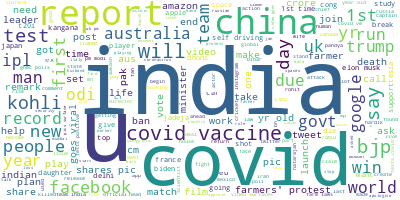

In [6]:
from wordcloud import WordCloud
long_string = ','.join(list(df_clean['news_headline'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [7]:
df_clean.news_article = df_clean.news_article.apply(lambda x: re.sub(r"[\,\.\'\"\`]", '', x))
df_clean.news_headline = df_clean.news_headline.apply(lambda x: re.sub(r"[\,\.\'\"\`]", '', x))



df_clean_test.news_article = df_clean_test.news_article.apply(lambda x: re.sub(r"[\,\.\'\"\`]", '', x))
df_clean_test.news_headline = df_clean_test.news_headline.apply(lambda x: re.sub(r"[\,\.\'\"\`]", '', x))

In [8]:
tknzr = TweetTokenizer()
df_clean['article_tokens'] = df_clean['news_article'].apply(tknzr.tokenize)
df_clean['headline_tokens'] = df_clean['news_headline'].apply(tknzr.tokenize)



df_clean_test['article_tokens'] = df_clean_test['news_article'].apply(tknzr.tokenize)
df_clean_test['headline_tokens'] = df_clean_test['news_headline'].apply(tknzr.tokenize)



df_clean.head(20)

,Id,news_article,news_headline,article_tokens,headline_tokens
0,1,deepminds ai system alphafold has been recogni...,50-year-old problem of biology solved by artif...,"[deepminds, ai, system, alphafold, has, been, ...","[50, -, year-old, problem, of, biology, solved..."
1,2,microsoft teams will stop working on internet ...,microsoft teams to stop working on internet ex...,"[microsoft, teams, will, stop, working, on, in...","[microsoft, teams, to, stop, working, on, inte..."
2,3,china in response to reports of us adding chin...,hope us wont erect barriers to cooperation: ch...,"[china, in, response, to, reports, of, us, add...","[hope, us, wont, erect, barriers, to, cooperat..."
3,4,the global smartphone sales in the third quart...,global smartphone sales in q3 falls 57% to 366...,"[the, global, smartphone, sales, in, the, thir...","[global, smartphone, sales, in, q3, falls, 57,..."
4,5,the european union (eu) is hoping that us pres...,eu hoping biden will clarify us position on di...,"[the, european, union, (, eu, ), is, hoping, t...","[eu, hoping, biden, will, clarify, us, positio..."
5,6,the members of the joint parliamentary committ...,parliamentary panel divided over key issues in...,"[the, members, of, the, joint, parliamentary, ...","[parliamentary, panel, divided, over, key, iss..."
6,7,google ceo sundar pichai facebook ceo mark zuc...,google facebook sign french govts tech for goo...,"[google, ceo, sundar, pichai, facebook, ceo, m...","[google, facebook, sign, french, govts, tech, ..."
7,8,facebook could soon face the first antitrust a...,facebook could soon face its 1st antitrust sui...,"[facebook, could, soon, face, the, first, anti...","[facebook, could, soon, face, its, 1st, antitr..."
8,9,canadas finance department on monday said it p...,canada plans digital tax on tech majors like f...,"[canadas, finance, department, on, monday, sai...","[canada, plans, digital, tax, on, tech, majors..."
9,10,twitters audio spaces that will allow users to...,twitters audio spaces to include transcription...,"[twitters, audio, spaces, that, will, allow, u...","[twitters, audio, spaces, to, include, transcr..."


In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [(lemmatizer.lemmatize(w)) for w in text]

In [10]:
df_clean['lemmatized_article_tokens'] = df_clean['article_tokens'].apply(lemmatize_text)
df_clean['lemmatized_headline_tokens'] = df_clean['headline_tokens'].apply(lemmatize_text)

df_clean_test['lemmatized_article_tokens'] = df_clean_test['article_tokens'].apply(lemmatize_text)
df_clean_test['lemmatized_headline_tokens'] = df_clean_test['headline_tokens'].apply(lemmatize_text)



df_clean[['article_tokens','lemmatized_article_tokens','headline_tokens','lemmatized_headline_tokens']].head(20)

,article_tokens,lemmatized_article_tokens,headline_tokens,lemmatized_headline_tokens
0,"[deepminds, ai, system, alphafold, has, been, ...","[deepminds, ai, system, alphafold, ha, been, r...","[50, -, year-old, problem, of, biology, solved...","[50, -, year-old, problem, of, biology, solved..."
1,"[microsoft, teams, will, stop, working, on, in...","[microsoft, team, will, stop, working, on, int...","[microsoft, teams, to, stop, working, on, inte...","[microsoft, team, to, stop, working, on, inter..."
2,"[china, in, response, to, reports, of, us, add...","[china, in, response, to, report, of, u, addin...","[hope, us, wont, erect, barriers, to, cooperat...","[hope, u, wont, erect, barrier, to, cooperatio..."
3,"[the, global, smartphone, sales, in, the, thir...","[the, global, smartphone, sale, in, the, third...","[global, smartphone, sales, in, q3, falls, 57,...","[global, smartphone, sale, in, q3, fall, 57, %..."
4,"[the, european, union, (, eu, ), is, hoping, t...","[the, european, union, (, eu, ), is, hoping, t...","[eu, hoping, biden, will, clarify, us, positio...","[eu, hoping, biden, will, clarify, u, position..."
5,"[the, members, of, the, joint, parliamentary, ...","[the, member, of, the, joint, parliamentary, c...","[parliamentary, panel, divided, over, key, iss...","[parliamentary, panel, divided, over, key, iss..."
6,"[google, ceo, sundar, pichai, facebook, ceo, m...","[google, ceo, sundar, pichai, facebook, ceo, m...","[google, facebook, sign, french, govts, tech, ...","[google, facebook, sign, french, govts, tech, ..."
7,"[facebook, could, soon, face, the, first, anti...","[facebook, could, soon, face, the, first, anti...","[facebook, could, soon, face, its, 1st, antitr...","[facebook, could, soon, face, it, 1st, antitru..."
8,"[canadas, finance, department, on, monday, sai...","[canada, finance, department, on, monday, said...","[canada, plans, digital, tax, on, tech, majors...","[canada, plan, digital, tax, on, tech, major, ..."
9,"[twitters, audio, spaces, that, will, allow, u...","[twitter, audio, space, that, will, allow, use...","[twitters, audio, spaces, to, include, transcr...","[twitter, audio, space, to, include, transcrip..."


In [11]:
stop_words = set(stopwords.words('english'))
df_clean['article_final_tokens'] = df_clean['lemmatized_article_tokens'].apply(lambda x: [item for item in x if item not in stop_words])
df_clean['headline_final_tokens'] = df_clean['lemmatized_headline_tokens'].apply(lambda x: [item for item in x if item not in stop_words])




df_clean_test['article_final_tokens'] = df_clean_test['lemmatized_article_tokens'].apply(lambda x: [item for item in x if item not in stop_words])
df_clean_test['headline_final_tokens'] = df_clean_test['lemmatized_headline_tokens'].apply(lambda x: [item for item in x if item not in stop_words])

In [12]:
processed_docs = df_clean['article_final_tokens']
processed_docs_test = df_clean_test['article_final_tokens']
training_data = processed_docs[:]
testing_data = processed_docs_test[:]

In [13]:
dictionary = gensim.corpora.Dictionary(training_data)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 3d
1 50
2 ai
3 alphafold
4 atom
5 biological
6 biology
7 challenge
8 complex
9 deepmind
10 deepminds


In [14]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus_training = [dictionary.doc2bow(doc) for doc in training_data]
bow_corpus_testing = [dictionary.doc2bow(doc) for doc in testing_data]

In [15]:
df_clean['news_headline_word_cloud'] =df_clean['headline_final_tokens'].apply(lambda x: ' '.join([w for w in x if len(w)>3]))

In [16]:
All_words = df_clean['news_headline_word_cloud'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = All_words.index.values[2:50],
                y = All_words.values[2:50],
                marker= dict(colorscale='Jet', color = All_words.values[2:100]),
                text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (cleaned) Word frequencies in dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Cleaned Words')


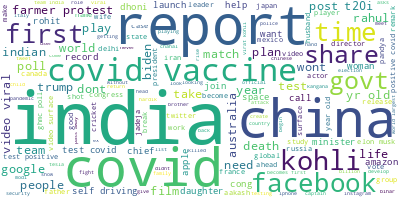

In [17]:
from wordcloud import WordCloud
long_string = ','.join(list(df_clean['news_headline_word_cloud'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [18]:
lda_model =  gensim.models.LdaMulticore(bow_corpus_training, 
                                   num_topics = 7, 
                                   id2word = dictionary,
                                   passes = 30,
                                   workers = 12)

In [19]:
pprint(lda_model.print_topics())

[(0,
  '0.017*"minister" + 0.015*"bjp" + 0.015*"government" + 0.014*"election" + '
  '0.013*"farmer" + 0.013*"leader" + 0.012*"party" + 0.012*"congress" + '
  '0.012*"state" + 0.010*"delhi"'),
 (1,
  '0.027*"film" + 0.017*"actor" + 0.013*"actress" + 0.009*"wrote" + '
  '0.009*"like" + 0.007*"time" + 0.007*"upcoming" + 0.007*"khan" + '
  '0.006*"trump" + 0.006*"instagram"'),
 (2,
  '0.020*"$" + 0.015*"company" + 0.013*"billion" + 0.012*"%" + 0.012*"tesla" + '
  '0.009*"vehicle" + 0.009*"million" + 0.008*"ceo" + 0.008*"musk" + '
  '0.007*"electric"'),
 (3,
  '0.016*"user" + 0.012*"facebook" + 0.009*"video" + 0.008*"twitter" + '
  '0.008*"google" + 0.008*"apple" + 0.008*"company" + 0.007*"feature" + '
  '0.007*"new" + 0.007*"app"'),
 (4,
  '0.032*"vaccine" + 0.030*"19" + 0.030*"covid" + 0.013*"coronavirus" + '
  '0.011*"positive" + 0.009*"health" + 0.009*"country" + 0.008*"tested" + '
  '0.008*"uk" + 0.008*"trial"'),
 (5,
  '0.022*"australia" + 0.017*"match" + 0.016*"team" + 0.013*"run" +

In [20]:
def print_model(model):
    
    def print_topic(topic):
        topic_no, topic_repr = topic
        parts = topic_repr.split("+")
        words = [re.search('"(.*)"', part).group(1) for part in parts]
        return "{}: {}".format(topic_no, words)
    
    for topic in model.print_topics():
        print(print_topic(topic))
        
    
print_model(lda_model)

0: ['minister', 'bjp', 'government', 'election', 'farmer', 'leader', 'party', 'congress', 'state', 'delhi']
1: ['film', 'actor', 'actress', 'wrote', 'like', 'time', 'upcoming', 'khan', 'trump', 'instagram']
2: ['$', 'company', 'billion', '%', 'tesla', 'vehicle', 'million', 'ceo', 'musk', 'electric']
3: ['user', 'facebook', 'video', 'twitter', 'google', 'apple', 'company', 'feature', 'new', 'app']
4: ['vaccine', '19', 'covid', 'coronavirus', 'positive', 'health', 'country', 'tested', 'uk', 'trial']
5: ['australia', 'match', 'team', 'run', 'captain', 'kohli', 'ipl', 'series', 'virat', 'test']
6: ['death', '₹', 'new', 'world', 'space', 'country', 'china', 'case', 'crore', 'reported']


In [21]:
# ['sports', 'technology', 'politics', 'science', 'world', 'entertainment', 'automobile']
topic_mapping = {
    0: "Politics",
    1: "Entertainment",
    2: "Automobile",
    3: "Technology",
    4: "World",
    5: "Sports",
    6: "Science"
}

In [22]:
document_num = 4
bow_doc_y = bow_corpus_testing[document_num]

for i in range(len(bow_doc_y)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_y[i][0], 
                                                     dictionary[bow_doc_y[i][0]], 
                                                     bow_doc_y[i][1]))

Word 13 ("2021") appears 1 time.
Word 40 ("company") appears 1 time.
Word 150 ("new") appears 1 time.
Word 186 ("space") appears 2 time.
Word 212 ("take") appears 1 time.
Word 250 ("commercial") appears 1 time.
Word 277 ("motor") appears 1 time.
Word 282 ("short") appears 1 time.
Word 290 ("aim") appears 1 time.
Word 313 ("’") appears 1 time.
Word 319 ("expected") appears 1 time.
Word 504 ("test") appears 1 time.
Word 597 ("didnt") appears 1 time.
Word 758 ("mexico") appears 1 time.
Word 928 ("saturday") appears 1 time.
Word 1148 ("sequence") appears 1 time.
Word 1156 ("complete") appears 1 time.
Word 1227 ("passenger") appears 1 time.
Word 1277 ("cut") appears 1 time.
Word 1386 ("rocket") appears 1 time.
Word 1392 ("start") appears 1 time.
Word 1598 ("america") appears 1 time.
Word 1693 ("flight") appears 3 time.
Word 2024 ("returned") appears 1 time.


In [23]:
for index, score in sorted(lda_model[bow_corpus_testing[4]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6925426721572876	 
Topic: 0.020*"$" + 0.015*"company" + 0.013*"billion" + 0.012*"%" + 0.012*"tesla" + 0.009*"vehicle" + 0.009*"million" + 0.008*"ceo" + 0.008*"musk" + 0.007*"electric"

Score: 0.0839642807841301	 
Topic: 0.032*"vaccine" + 0.030*"19" + 0.030*"covid" + 0.013*"coronavirus" + 0.011*"positive" + 0.009*"health" + 0.009*"country" + 0.008*"tested" + 0.008*"uk" + 0.008*"trial"

Score: 0.08099808543920517	 
Topic: 0.010*"death" + 0.010*"₹" + 0.010*"new" + 0.010*"world" + 0.009*"space" + 0.009*"country" + 0.009*"china" + 0.009*"case" + 0.008*"crore" + 0.008*"reported"

Score: 0.07214349508285522	 
Topic: 0.027*"film" + 0.017*"actor" + 0.013*"actress" + 0.009*"wrote" + 0.009*"like" + 0.007*"time" + 0.007*"upcoming" + 0.007*"khan" + 0.006*"trump" + 0.006*"instagram"

Score: 0.06009593605995178	 
Topic: 0.016*"user" + 0.012*"facebook" + 0.009*"video" + 0.008*"twitter" + 0.008*"google" + 0.008*"apple" + 0.008*"company" + 0.007*"feature" + 0.007*"new" + 0.007*"app"


In [24]:
print(lda_model.print_topic(index, 10))

0.016*"user" + 0.012*"facebook" + 0.009*"video" + 0.008*"twitter" + 0.008*"google" + 0.008*"apple" + 0.008*"company" + 0.007*"feature" + 0.007*"new" + 0.007*"app"


In [25]:
print(df_clean.article_final_tokens[4808])

['actress', 'nushrratt', 'bharuccha', 'ha', 'starred', 'various', 'romantic-comedy', 'film', 'said', 'want', 'explore', 'genre', 'well', 'getting', 'opportunity', 'feel', 'open', 'newer', 'different', 'castingthey', 'trusting', 'actor', 'much', 'want', 'thing', 'dont', 'trust', '?', 'added']


In [26]:
topic_probability = []
lda_vector = lda_model[bow_corpus_testing]
for t in lda_vector:
      topic_probability.append(t)
results_test = pd.DataFrame(topic_probability,columns=["Politics","Entertainment","Automobile","Technology",
                                                       "Science","Sports","World"])
print(results_test)

              Politics    Entertainment        Automobile        Technology  \
0       (2, 0.2888604)   (3, 0.6835732)              None              None   
1      (2, 0.97138447)             None              None              None   
2      (0, 0.36258197)  (1, 0.18923622)    (3, 0.4208821)              None   
3      (3, 0.19951305)   (4, 0.6608887)   (6, 0.11574462)              None   
4     (1, 0.072145425)  (2, 0.69260305)  (3, 0.060096413)  (4, 0.083977275)   
...                ...              ...               ...               ...   
1558   (2, 0.46921128)   (4, 0.2233283)    (6, 0.2845003)              None   
1559  (4, 0.104710974)  (6, 0.86876607)              None              None   
1560   (4, 0.11007096)   (6, 0.8421716)              None              None   
1561   (0, 0.40620458)  (3, 0.22281705)   (6, 0.34708858)              None   
1562    (1, 0.3190587)  (4, 0.53236127)    (5, 0.1127323)              None   

              Science Sports World  
0             

In [27]:
test_df.iloc[:,1:2]

,news_headline
0,Porn star jokes she could post nudes on Insta ...
1,Satellite pics show remains of SpaceX's rocket...
2,Not in favour of recommending such games: Top ...
3,Researchers develop first AI tool to detect CO...
4,Virgin Galactic's test space flight cut short ...
...,...
1558,China to open world's largest radio telescope ...
1559,Chinese spacecraft brings 1st lunar samples in...
1560,'Forever chemicals' used in outdoor gear found...
1561,US Space Force personnel will be called 'Guard...


In [28]:
final_topics = pd.DataFrame(columns=['news_category'])
for t in lda_vector:
    topic_num=0
    curr_prob=0
    for prob in t:
        if(prob[1]>curr_prob):
            curr_prob=prob[1]
            topic_num=prob[0]
    final_topics.loc[len(final_topics.index)] = [topic_mapping[topic_num]]
final_topics.head()

,news_category
0,Technology
1,Automobile
2,Technology
3,World
4,Automobile


In [29]:
# test = pd.DataFrame()
final_topics['headline']=test_df.iloc[:,1:2]
final_topics['article']=test_df.iloc[:,2:3]
final_topics['news_category'] = final_topics['news_category'].str.lower()
final_topics.head()

,news_category,headline,article
0,technology,Porn star jokes she could post nudes on Insta ...,Porn star Kendra Sunderland's Instagram accoun...
1,automobile,Satellite pics show remains of SpaceX's rocket...,Satellite images showed the remains of Elon Mu...
2,technology,Not in favour of recommending such games: Top ...,National Commission for Protection of Child Ri...
3,world,Researchers develop first AI tool to detect CO...,A team of researchers from the University of V...
4,automobile,Virgin Galactic's test space flight cut short ...,Richard Branson's space tourism company Virgin...


In [30]:
test_df.head()

,Unnamed: 0,news_headline,news_article,news_category
0,0,Porn star jokes she could post nudes on Insta ...,Porn star Kendra Sunderland's Instagram accoun...,technology
1,1,Satellite pics show remains of SpaceX's rocket...,Satellite images showed the remains of Elon Mu...,technology
2,2,Not in favour of recommending such games: Top ...,National Commission for Protection of Child Ri...,technology
3,3,Researchers develop first AI tool to detect CO...,A team of researchers from the University of V...,technology
4,4,Virgin Galactic's test space flight cut short ...,Richard Branson's space tourism company Virgin...,technology


In [31]:
final_topics.to_csv('news_topics.csv', index=True, header=False)

In [32]:
final_topics

,news_category,headline,article
0,technology,Porn star jokes she could post nudes on Insta ...,Porn star Kendra Sunderland's Instagram accoun...
1,automobile,Satellite pics show remains of SpaceX's rocket...,Satellite images showed the remains of Elon Mu...
2,technology,Not in favour of recommending such games: Top ...,National Commission for Protection of Child Ri...
3,world,Researchers develop first AI tool to detect CO...,A team of researchers from the University of V...
4,automobile,Virgin Galactic's test space flight cut short ...,Richard Branson's space tourism company Virgin...
...,...,...,...
1558,automobile,China to open world's largest radio telescope ...,China will open the world's largest radio tele...
1559,science,Chinese spacecraft brings 1st lunar samples in...,China's Chang'e-5 probe successfully landed in...
1560,science,'Forever chemicals' used in outdoor gear found...,"""Forever chemicals"" used in water-repellent ou..."
1561,politics,US Space Force personnel will be called 'Guard...,The members of the US Space Force will be call...


In [33]:
from sklearn.metrics import confusion_matrix

y_true = test_df['news_category']
y_pred = final_topics['news_category']

cm = confusion_matrix(y_true, y_pred, labels=category_count)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.figure(figsize=(10, 8), dpi=80)
    plt.show()

Confusion matrix, without normalization
[[204   0   1   4   9   7   0]
 [ 13 111   0  21  13  13  54]
 [  4   1 199   4   3   7   7]
 [  1  25   0 107  57   1  34]
 [ 52  23   1  29  50  27  41]
 [  7   5   0   7   2 198   3]
 [ 22  27   0   0  10   1 158]]


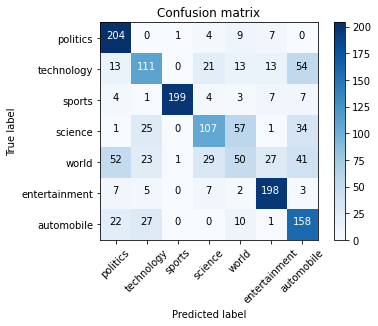

In [35]:
plot_confusion_matrix(cm,category_count,False)

Normalized confusion matrix
[[0.91 0.   0.   0.02 0.04 0.03 0.  ]
 [0.06 0.49 0.   0.09 0.06 0.06 0.24]
 [0.02 0.   0.88 0.02 0.01 0.03 0.03]
 [0.   0.11 0.   0.48 0.25 0.   0.15]
 [0.23 0.1  0.   0.13 0.22 0.12 0.18]
 [0.03 0.02 0.   0.03 0.01 0.89 0.01]
 [0.1  0.12 0.   0.   0.05 0.   0.72]]


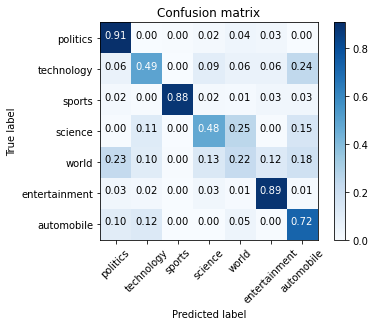

In [36]:
plot_confusion_matrix(cm,category_count,True)

In [37]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
f_measure = (2*recall*precision)/(recall+precision)

In [38]:
print(np.mean(recall))
print(np.mean(precision))
print(np.mean(f_measure))

0.6572682543900712
0.6460387734994486
0.6423458664609315


In [41]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average='micro')

0.6570697376839412